In [34]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
from IPython.display import Image


%matplotlib inline

## Datasets

I use two datasets:

__samples__ consists of 19665 in-situ observations of 13C and 14C Primary Production measurments at different depts matched to monthly satellite fields for input features. The data was divided in to a training (80%) and test (20%) dataset and used to fit a Random Forest and XGBoost model. The csv file below include information about test/train allocations, observed PP (pp_obs column) and predicted PP from RF and XGboost (pp_rf, pp_xgboost columns)

__subset__ is based on monthly global satellite fields for the year 2010. I took 39 x 10000 random samples from each monthly satellite field and assigned each set of 10000 a depth between 5 and 200 meter with a 5 meter intervall. The resulting dataset consisting of 10000 * 39 *12 samples was randomly subsampled to 19665 rows. This dataset is assumed to represent the global distribution of satellite-derived properties that we use as input features.


### Load the datasets:

In [25]:
#Samples
samples = pd.read_csv("http://monhegan.unh.edu/ppforest/global_PP_samples.csv")
sampstr = "insitu samples"

#subset
subset  = pd.read_csv("http://monhegan.unh.edu/ppforest/global_PP_subset.csv")
globstr = "global subset"

Let's start with plotting the observed and predicted PP for both models using ther samples dataset:

Text(0.5, 1.0, 'Random Forest')

<Figure size 640x480 with 0 Axes>

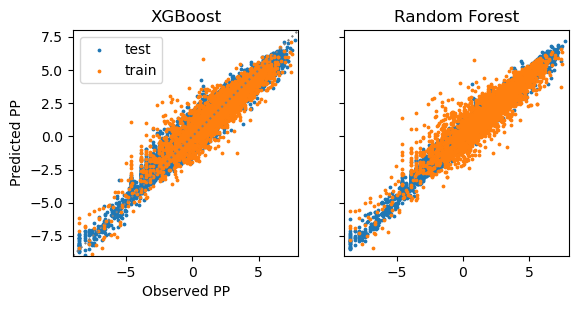

In [26]:
plt.clf()
mask = samples["test"]
fig,axes = plt.subplots(1,2, sharey=True, sharex=True)

ax = axes[0] 
ax.scatter(samples["pp_obs"][~mask], samples["pp_xgb"][~mask],3, label="test")
ax.scatter(samples["pp_obs"][mask], samples["pp_xgb"][mask],3, label="train")
ax.set_xlabel("Observed PP")
ax.set_ylabel("Predicted PP")
ax.set_title("XGBoost")
ax.set_aspect(1)
ax.set_xlim(-9,8)
ax.set_ylim(-9,8)
ax.plot([-9,8], [-9,8], ":", c="0.5")
ax.legend()

ax = axes[1] 
ax.scatter(samples["pp_obs"][~mask], samples["pp_rf"][~mask],3, label="test")
ax.scatter(samples["pp_obs"][mask], samples["pp_rf"][mask],3, label="train")
ax.set_aspect(1)
ax.set_title("Random Forest")




Both models show very similar results and have reasonably good skills (R$^2$=0.84 for RF and R$^2$=0.86 for XGB with the test data). it looks very different when comparing the two models using the subset dataset though:

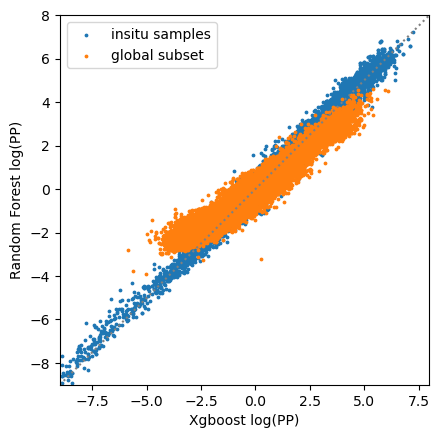

In [27]:
plt.clf()
plt.scatter(samples["pp_xgb"], samples["pp_rf"],3, label=sampstr)
plt.scatter(subset["pp_xgb"], subset["pp_rf"],3, label=globstr)
plt.xlabel("Xgboost log(PP)")
plt.ylabel("Random Forest log(PP)")
plt.gca().set_aspect(1)
plt.xlim(-9,8)
plt.ylim(-9,8)
plt.plot([-9,8], [-9,8], ":", c="0.5")
plt.legend()


Neither model is able to predict the highest or lowest values  when using input features from _subset_ compared to _samples_. I see three issues -

1. Why does the _samples_ dataset have a larger range of PP predictions than _subset_? Is it because  conditions where very low PP values are predicted are too rare?
2. Why does the Random Forest model have less of variance than XGBoost? 
3. Is it possible to say anything about which model is most correct?

The reason for my concern is that the aggregated PP is very different for the two models: 

In [33]:
print(f" Sum of PP from Random Forest: {np.sum(np.exp(subset["pp_rf"]))}")
print(f" Sum of PP from XGBoost:       {np.sum(np.exp(subset["pp_xgb"]))}")

 Sum of PP from Random Forest: 68365.27490220523
 Sum of PP from XGBoost:       126784.17463216199


The result is quite important since My global estimate of PP using Random Forest is ~50GT/Yr using RF and ~80GT/Yr for XGBoost. The former result is very close to what other models show and not very interesting, the latter very interesting if we can motivate why using XGBoost. Here are some examples of earlier studies including our estimates:

![Image of Yaktocat](http://monhegan.unh.edu/ppforest/PP_different_studies.png)

Here are some fugures showing the difference beteen XGBoost and Random Forest for a given month at a different depths:

![Image of Yaktocat](http://monhegan.unh.edu/ppforest/xg_rf_diff_figs/rf_xg_diff_2010-05-01_010.png)

![Image of Yaktocat](http://monhegan.unh.edu/ppforest/xg_rf_diff_figs/rf_xg_diff_2010-05-01_025.png)


![Image of Yaktocat](http://monhegan.unh.edu/ppforest/xg_rf_diff_figs/rf_xg_diff_2010-05-01_050.png)

![Image of Yaktocat](http://monhegan.unh.edu/ppforest/xg_rf_diff_figs/rf_xg_diff_2010-05-01_075.png)

![Image of Yaktocat](http://monhegan.unh.edu/ppforest/xg_rf_diff_figs/rf_xg_diff_2010-05-01_100.png)


I've also added some figures showing how the distribution of different input features compare wbetween the two datasets:

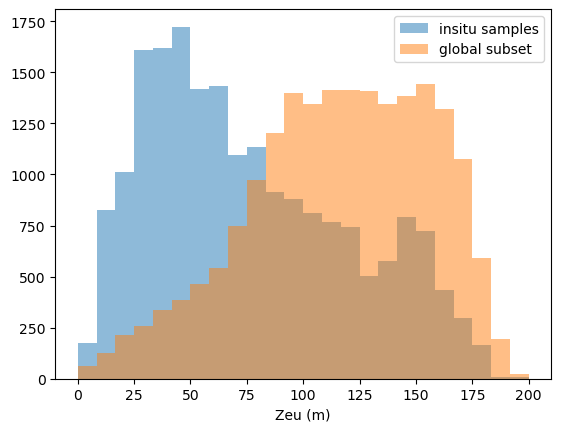

In [29]:
plt.clf()
plt.hist(samples.Zeu, np.linspace(0,200,25), alpha=0.5, label=sampstr)
plt.hist(subset.Zeu,  np.linspace(0,200,25), alpha=0.5, label=globstr)
plt.xlabel("Zeu (m)")
plt.legend()

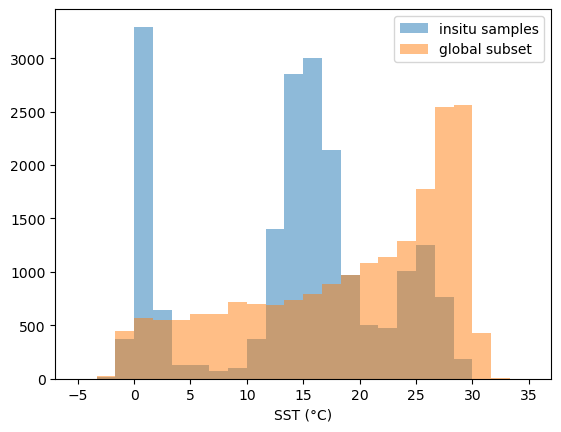

In [30]:
plt.clf()
plt.hist(samples.sst, np.linspace(-5,35,25), alpha=0.5, label=sampstr)
plt.hist(subset.sst,  np.linspace(-5,35,25), alpha=0.5, label=globstr)
plt.xlabel("SST (°C)")
plt.legend()

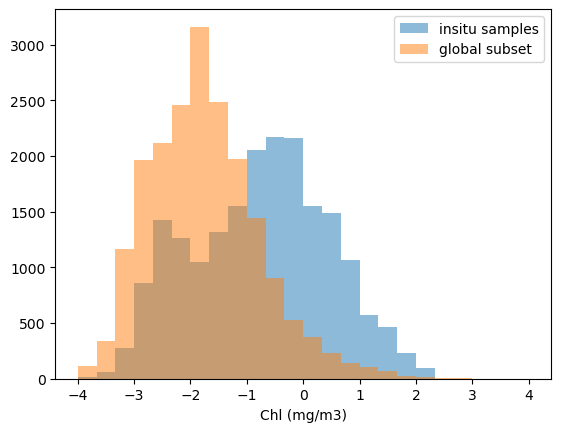

In [31]:
plt.clf()
plt.hist(samples.chl, np.linspace(-4,4,25), alpha=0.5, label=sampstr)
plt.hist(np.log(subset.chl),  np.linspace(-4,4,25), alpha=0.5, label=globstr)
plt.xlabel("Chl (mg/m3)")
plt.legend()

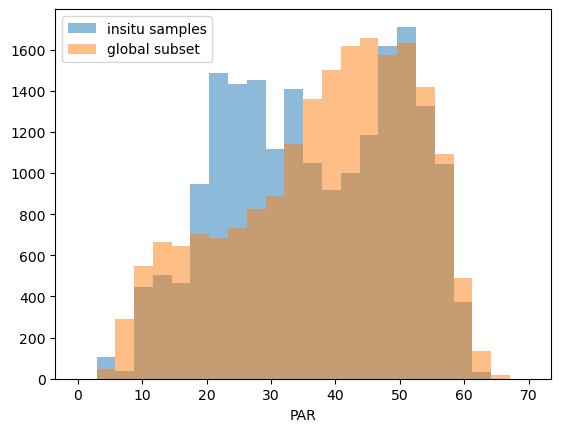

In [32]:
plt.clf()
plt.hist(samples.sat_par, np.linspace(0,70,25), alpha=0.5, label=sampstr)
plt.hist(subset.sat_par,  np.linspace(0,70,25), alpha=0.5, label=globstr)
plt.xlabel("PAR")
plt.legend()